In [53]:
import numpy as np
import cv2 as cv
from PIL import Image
import PIL
from random import randint
from matplotlib import pyplot as plt

In [6]:
face = Image.open("./data/face300_mod2/001.png")
template = Image.open("./data/Chinese_card_constructor.png")

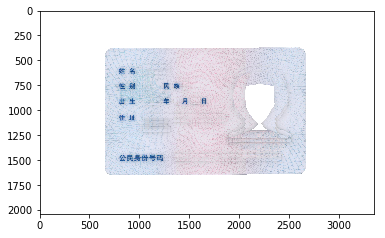

In [7]:
plt.imshow(template);

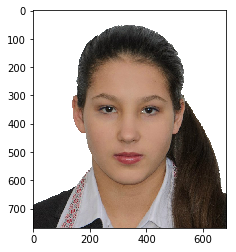

In [8]:
plt.imshow(face);

In [114]:
face.size

(682, 768)

In [136]:
crop_len = 50
face_cropped = face.crop(
    (crop_len, crop_len, face.size[0] - crop_len, face.size[1] - crop_len)
)

In [132]:
face_cropped.size

(562, 648)

In [133]:
w = 620
h = int(face_cropped.size[1] * (620.0 / face_cropped.size[0]))
face_cropped_620 = face_cropped.resize((w, h), PIL.Image.ANTIALIAS)

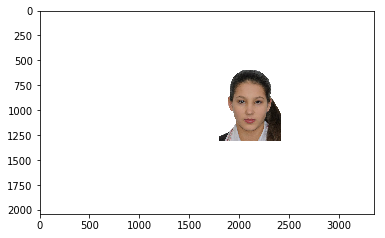

In [134]:
temp = Image.new('RGBA', template.size, 0)
temp.paste(face_cropped_620, (1800, 600))
plt.imshow(temp);

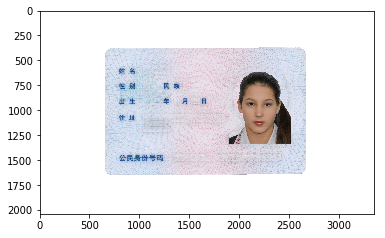

In [135]:
temp = Image.new('RGBA', template.size, 0)
temp.paste(face_cropped_620, (1894, 623))
rez = Image.alpha_composite(template, temp)
rez.save('opop.png')
plt.imshow(rez);

# Get credentials

In [151]:
!pip install requests lxml

    100% |████████████████████████████████| 61kB 542kB/s ta 0:00:011
    100% |████████████████████████████████| 5.6MB 9.1MB/s eta 0:00:011
    100% |████████████████████████████████| 143kB 18.3MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 12.9MB/s ta 0:00:01
    100% |████████████████████████████████| 163kB 17.9MB/s ta 0:00:01


In [152]:
from grab_fake_chinese_credentials import get_chinese_creds

In [153]:
creds = get_chinese_creds(100)

In [154]:
creds[25]

{'address': '安徽省六安地区霍邱县',
 'birthday': datetime.date(1972, 7, 31),
 'id': '342423197207318023',
 'name': '龚颖',
 'nationality': '汉',
 'sex': '女'}

# Add creds to template

In [155]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

In [191]:
def add_creds(template: PIL.Image, person: dict, color: tuple) -> PIL.Image:
    img = template.copy()
    draw = ImageDraw.Draw(img)

    line_len = 11
    address_lines = [
        person['address'][i * line_len: (i+1) * line_len]
        for i in range(5)
        if bool(person['address'][i * line_len: (i+1) * line_len])
    ]

    # brush configs
    font_path = "data/wts11.ttf"
    in_font_path = "data/Inconsolata-Regular.ttf"
    inb_font_path = "data/Inconsolata-Bold.ttf"
    font = ImageFont.truetype(font_path, 76)
    name_font = ImageFont.truetype(font_path, 90)
    birthday_font = ImageFont.truetype(inb_font_path, 82)

    # name
    draw.text((1010, 560), person['name'], color, font=name_font)

    # sex
    draw.text((1010, 720), person['sex'], color, font=font)

    # nationality
    draw.text((1460, 720), person['nationality'], color, font=font)

    # birthday
    y_birthday = 865
    draw.text((1040, y_birthday), str(person['birthday'].year), color, font=birthday_font)
    month_str = str(person['birthday'].month)
    x_month = 1330 if len(month_str) == 2 else 1330 + 30
    draw.text((x_month, y_birthday), month_str, color, font=birthday_font)
    day_str = str(person['birthday'].day)
    x_day = 1520 if len(day_str) == 2 else 1520 + 30
    draw.text((x_day, y_birthday), day_str, color, font=birthday_font)

    # address
    for i, line in enumerate(address_lines):
        draw.text((1010, 1040 + i * 100), line, color, font=font)

    # id
    for i, digit in enumerate(person['id']):
        draw.text(
            (1340 + i * 62, 1420),
            digit,
            color,
            font=ImageFont.truetype(inb_font_path, 100)
        )
        
    return img

In [159]:
template = Image.open("./data/Chinese_card_constructor.png")
card_with_creds = add_creds(template, creds[26])

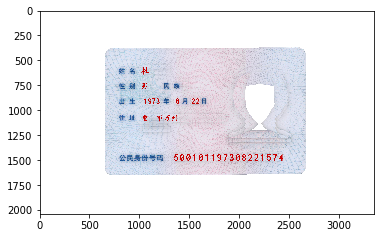

In [160]:
plt.imshow(card_with_creds);

# Choise color

In [175]:
r = g = b = np.absolute(np.random.normal(15, 5, 10).astype(int))

In [176]:
r

array([13, 17, 19, 26,  9, 19, 11, 17, 19, 18])

In [178]:
list(zip(r, g, b))

[(13, 13, 13),
 (17, 17, 17),
 (19, 19, 19),
 (26, 26, 26),
 (9, 9, 9),
 (19, 19, 19),
 (11, 11, 11),
 (17, 17, 17),
 (19, 19, 19),
 (18, 18, 18)]

# Lets make a pipeline!

In [180]:
from typing import List

In [192]:
def resize_to_width(img: PIL.Image, width: int) -> PIL.Image:
    height = int(face.size[1] * (620.0 / face.size[0]))
    return img.resize((width, height), PIL.Image.ANTIALIAS)

def crop_img(img: PIL.Image, value: int) -> PIL.Image:
    return img.crop(
        (value, value, img.size[0] - value, img.size[1] - value)
    )

def add_face(img: PIL.Image, face_dir_path: str) -> PIL.Image:
        face_path = '{face_dir_path}{number:0>3}.png'.format(
            face_dir_path=face_dir_path,
            number=randint(1, 267)
        )
        face = Image.open(face_path)
        face = crop_img(face, 50)
        face = resize_to_width(face, 620)
        temp = Image.new('RGBA', template.size, 0)
        temp.paste(face, (1894, 623))
        return Image.alpha_composite(img, temp)

def get_batch_of_color(count: int) -> List[tuple]:
    r = g = b = np.absolute(np.random.normal(15, 5, count).astype(int))
    return list(zip(r, g, b))
    
def get_card_generator(template_path: str, face_dir_path: str) -> PIL.Image:
    template = Image.open(template_path)
    batch_size = 35
    while True:
        creds = get_chinese_creds(batch_size)
        colors = get_batch_of_color(batch_size)
        for i, cred in enumerate(creds):
            template_with_creds = add_creds(template, cred, colors[i])
            yield add_face(template_with_creds, face_dir_path)

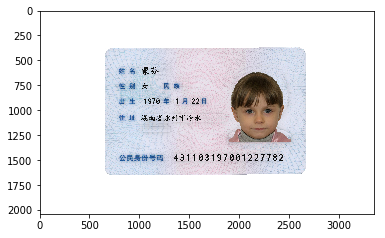

In [193]:
generator = get_card_generator(
    template_path="./data/Chinese_card_constructor.png",
    face_dir_path="./data/face300_mod2/",
)

plt.imshow(generator.__next__());

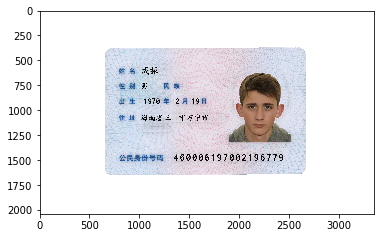

In [194]:
plt.imshow(generator.__next__());

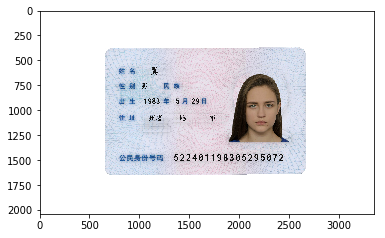

In [195]:
plt.imshow(generator.__next__());

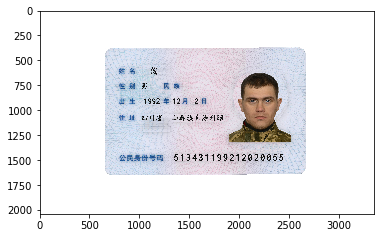

In [196]:
plt.imshow(generator.__next__());

In [197]:
sample = generator.__next__()
sample.save('sample.png')